In [1]:
# ---- 1. Import ----
import sagemaker
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import RandomCutForest
from sagemaker.inputs import TrainingInput

# ---- 2. Session and role ----
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
print(f"SageMaker role: {role}")


sagemaker.config INFO - Fetched defaults config from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3Bucket
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.Session.DefaultS3ObjectKeyPrefix
SageMaker role: arn:aws:iam::704428060689:role/datazone_usr_role_69984034nn18v5_dlxky52fkk2e5d


In [2]:
# ---- 3. Download CSV from S3 ----
bucket = 'my-anomaly-detection-workshop'
key = 'cpu_utilization_asg_misconfiguration.csv'

s3 = boto3.client('s3')

local_file = 'local_data.csv'
s3.download_file(Bucket=bucket, Key=key, Filename=local_file)

print(f"Downloaded {key} to {local_file}")


Downloaded cpu_utilization_asg_misconfiguration.csv to local_data.csv


In [3]:
# ---- 4. Load CSV into pandas ----
df = pd.read_csv(local_file)
print(df.columns)
df.head()


Index(['timestamp', 'value'], dtype='object')


,timestamp,value
0,2014-05-14 01:14:00,85.835
1,2014-05-14 01:19:00,88.167
2,2014-05-14 01:24:00,44.595
3,2014-05-14 01:29:00,56.282
4,2014-05-14 01:34:00,36.534


In [4]:
# ---- 5. Prepare single-column CSV for RCF ----
# Extract only 'value' column
values = df['value']

# Check data length (for RCF needs >= 1000)
print(f"Number of samples: {len(values)}")

values.to_csv('train_data.csv', header=False, index=False)
print("Created train_data.csv with only 'value' column")


Number of samples: 18050
Created train_data.csv with only 'value' column


In [5]:
# ---- 6. Upload prepared training data back to S3 ----
prefix_train = 'anomaly-detection-workshop/train'

train_s3_uri = sess.upload_data(path='train_data.csv', bucket=bucket, key_prefix=prefix_train)
print(f"Uploaded training data to: {train_s3_uri}")


Uploaded training data to: s3://my-anomaly-detection-workshop/anomaly-detection-workshop/train/train_data.csv


In [6]:
from sagemaker.inputs import TrainingInput

s3_train_input = TrainingInput(
    s3_data=train_s3_uri,
    content_type='text/csv'
)

print(f"TrainingInput: {s3_train_input}")


TrainingInput: <sagemaker.inputs.TrainingInput object at 0x7f02c79020d0>


In [7]:
rcf = RandomCutForest(
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    num_samples_per_tree=512,
    num_trees=50,
    output_path=f's3://{bucket}/output',
    sagemaker_session=sess
)


sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.Subnets
sagemaker.config INFO - Applied value from config key = SageMaker.TrainingJob.VpcConfig.SecurityGroupIds


In [8]:
values = pd.read_csv('train_data.csv', header=None)
print(values.shape)

(18050, 1)


In [9]:
import numpy as np

data_array = values.values.reshape(-1, 1)  # numpy array (18050, 1)
record_set = rcf.record_set(train=data_array)


In [10]:
rcf.fit(record_set)

2025-07-09 02:55:11 Starting - Starting the training job...
2025-07-09 02:55:27 Starting - Preparing the instances for training...
2025-07-09 02:55:44 Downloading - Downloading input data...
2025-07-09 02:56:20 Downloading - Downloading the training image........Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[07/09/2025 02:57:58 INFO 139694999979840] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-conf.json: {'num_sa

In [14]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer


In [16]:
rcf_predictor = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer()
)


----------------!

In [17]:
print(rcf_predictor.endpoint_name)

randomcutforest-2025-07-09-03-08-30-500


In [18]:
test_data = df['value'].values.reshape(-1, 1).astype('float32')
print(test_data[:5])




[[85.835]
 [88.167]
 [44.595]
 [56.282]
 [36.534]]


In [20]:
predictions = rcf_predictor.predict(test_data)

In [28]:
print("First 5 anomaly scores:")
for i, score in enumerate(predictions['scores'][:5]):
    print(f"{i}: anomaly score = {score}")


First 5 anomaly scores:
0: anomaly score = {'score': 2.6815386189}
1: anomaly score = {'score': 2.9641228381}
2: anomaly score = {'score': 0.9386399679}
3: anomaly score = {'score': 1.8688180216}
4: anomaly score = {'score': 1.3505926032}


In [29]:
print("First 5 anomaly scores (values only):")
for i, score_dict in enumerate(predictions['scores'][:5]):
    score_value = score_dict['score']
    print(f"{i}: {score_value:.4f}")


First 5 anomaly scores (values only):
0: 2.6815
1: 2.9641
2: 0.9386
3: 1.8688
4: 1.3506


In [32]:
print(rcf_predictor.endpoint_name)


randomcutforest-2025-07-09-03-08-30-500


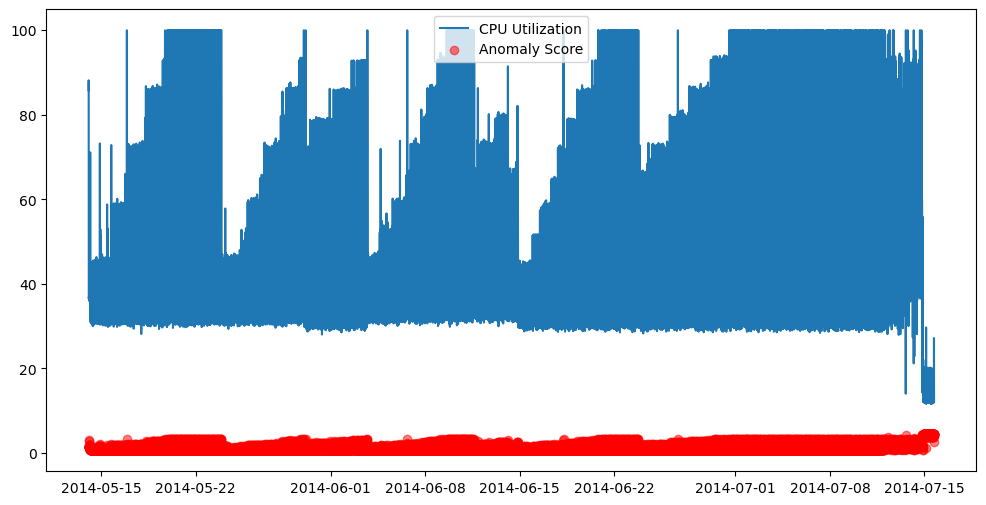

In [53]:
import matplotlib.pyplot as plt

scores = [s['score'] for s in predictions['scores']]
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='CPU Utilization')
plt.scatter(df['timestamp'], scores, color='red', label='Anomaly Score', alpha=0.5)
plt.legend()
plt.show()


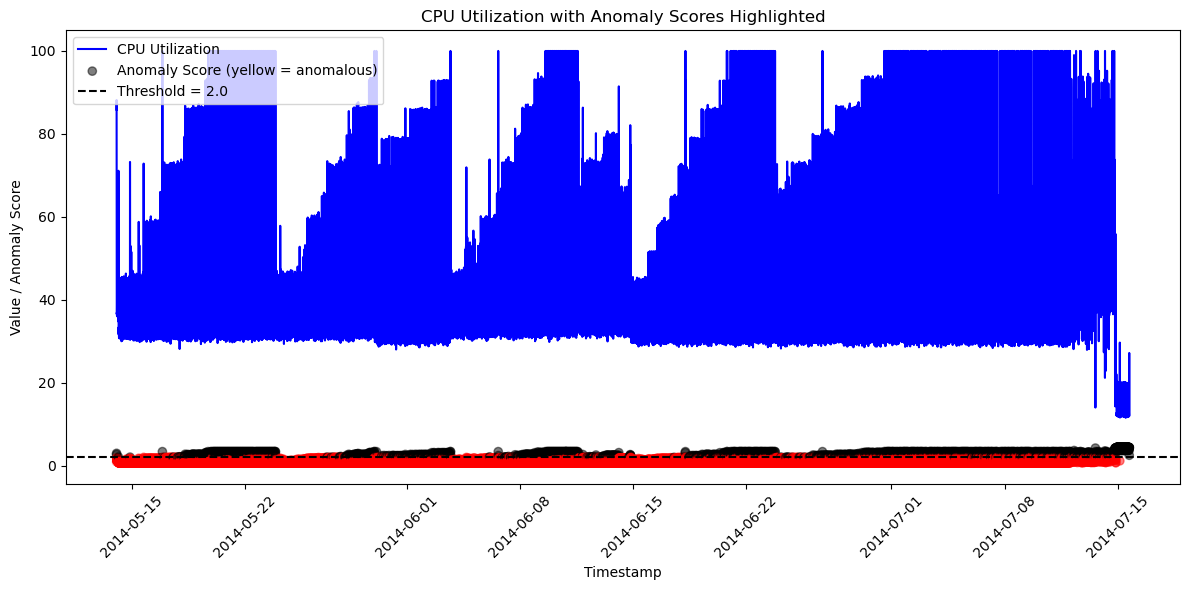

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy anomaly scores từ predictions
scores = np.array([s['score'] for s in predictions['scores']])

# Định nghĩa threshold
THRESHOLD = 2.0

# Phân loại màu theo threshold
colors = ['black' if s > THRESHOLD else 'red' for s in scores]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='CPU Utilization', color='blue')
plt.scatter(df['timestamp'], scores, c=colors, alpha=0.5, label='Anomaly Score (yellow = anomalous)')
plt.axhline(y=THRESHOLD, color='black', linestyle='--', label=f'Threshold = {THRESHOLD}')
plt.legend()
plt.title('CPU Utilization with Anomaly Scores Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Value / Anomaly Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


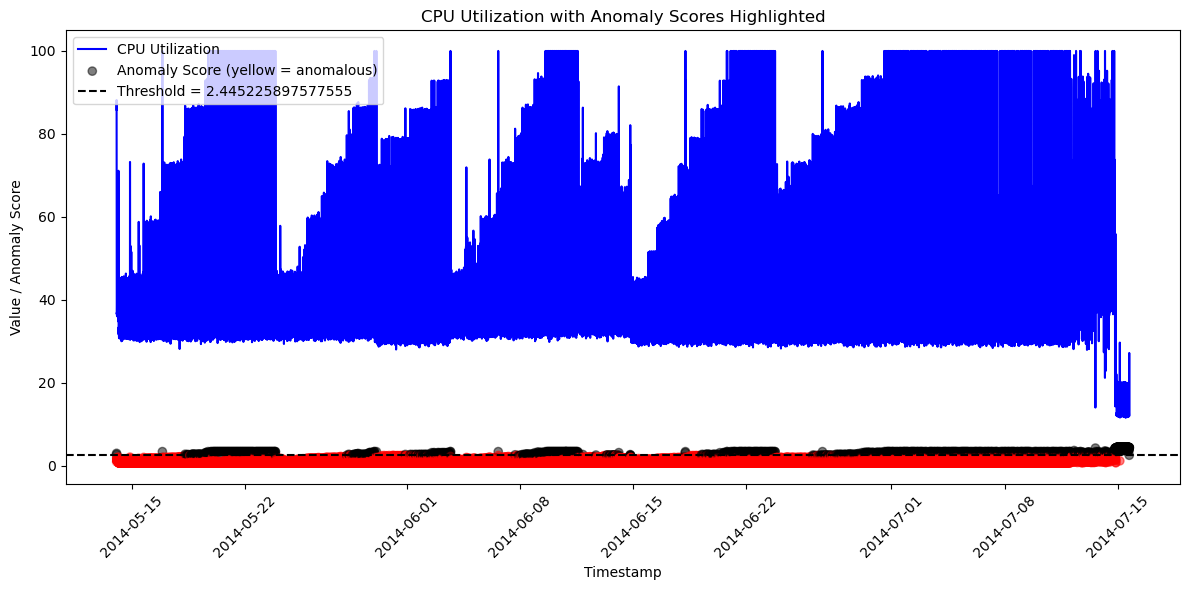

In [56]:
# Threshold động -  Threshold sẽ tự động tính theo độ phân tán của anomaly scores.
mean_score = np.mean(scores)
std_score = np.std(scores)
THRESHOLD = mean_score + 2 * std_score
# Phân loại màu theo threshold
colors = ['black' if s > THRESHOLD else 'red' for s in scores]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='CPU Utilization', color='blue')
plt.scatter(df['timestamp'], scores, c=colors, alpha=0.5, label='Anomaly Score (yellow = anomalous)')
plt.axhline(y=THRESHOLD, color='black', linestyle='--', label=f'Threshold = {THRESHOLD}')
plt.legend()
plt.title('CPU Utilization with Anomaly Scores Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Value / Anomaly Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

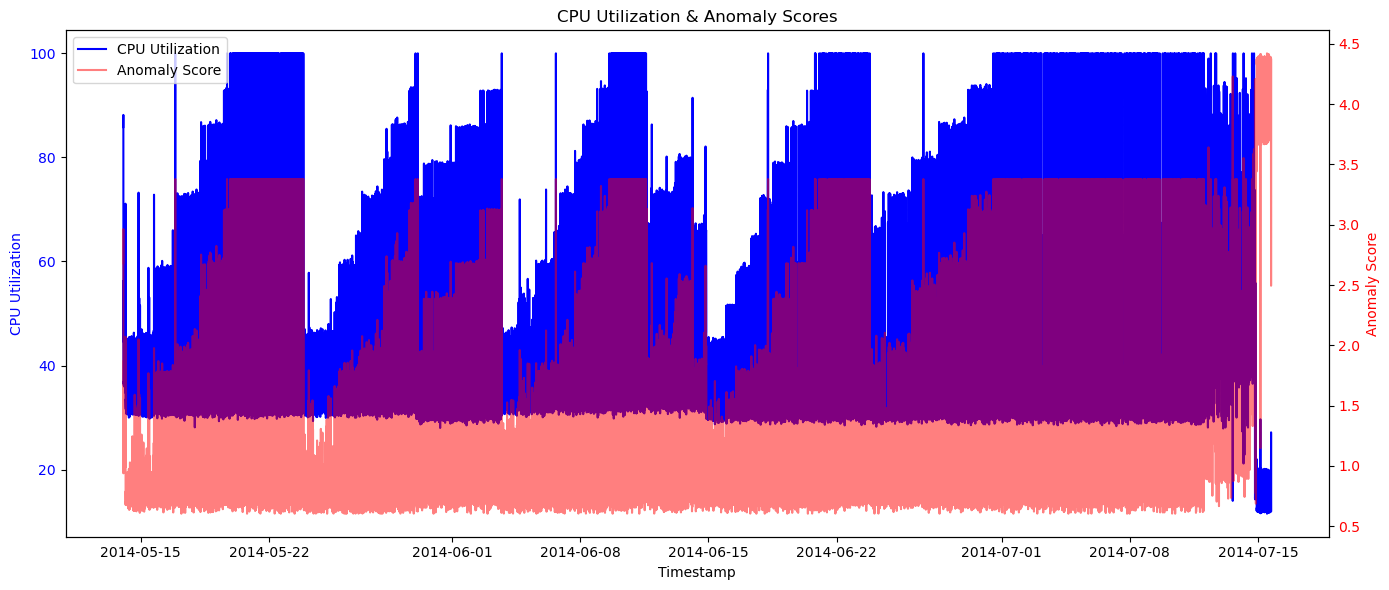

In [40]:
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(df['timestamp'], df['value'], color='blue', label='CPU Utilization')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('CPU Utilization', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df['timestamp'], scores, color='red', alpha=0.5, label='Anomaly Score')
ax2.set_ylabel('Anomaly Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('CPU Utilization & Anomaly Scores')
fig.tight_layout()
plt.show()


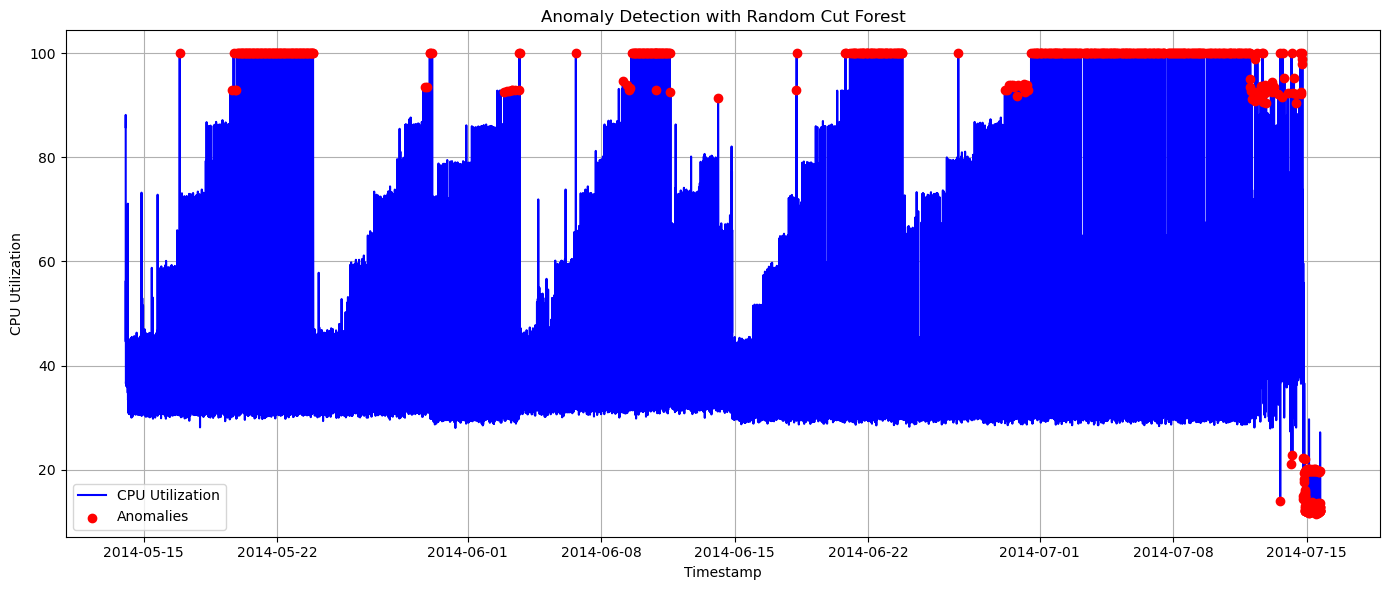

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy anomaly scores
scores = [s['score'] for s in predictions['scores']]
scores = np.array(scores)

# Cài ngưỡng bất thường (ví dụ: điểm nào có score > mean + 3*std sẽ là bất thường)
# Điểm K càng thấp thì càng nhạy, nhưng số k càng cao càng dễ bỏ qua những bất thường nhỏ bé, phải
# thận lựa chọn
threshold = scores.mean() + 3 * scores.std()
anomalies = scores > threshold

# Vẽ
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['value'], label='CPU Utilization', color='blue')
plt.scatter(df['timestamp'][anomalies], df['value'][anomalies], color='red', label='Anomalies', zorder=5)
plt.title('Anomaly Detection with Random Cut Forest')
plt.xlabel('Timestamp')
plt.ylabel('CPU Utilization')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


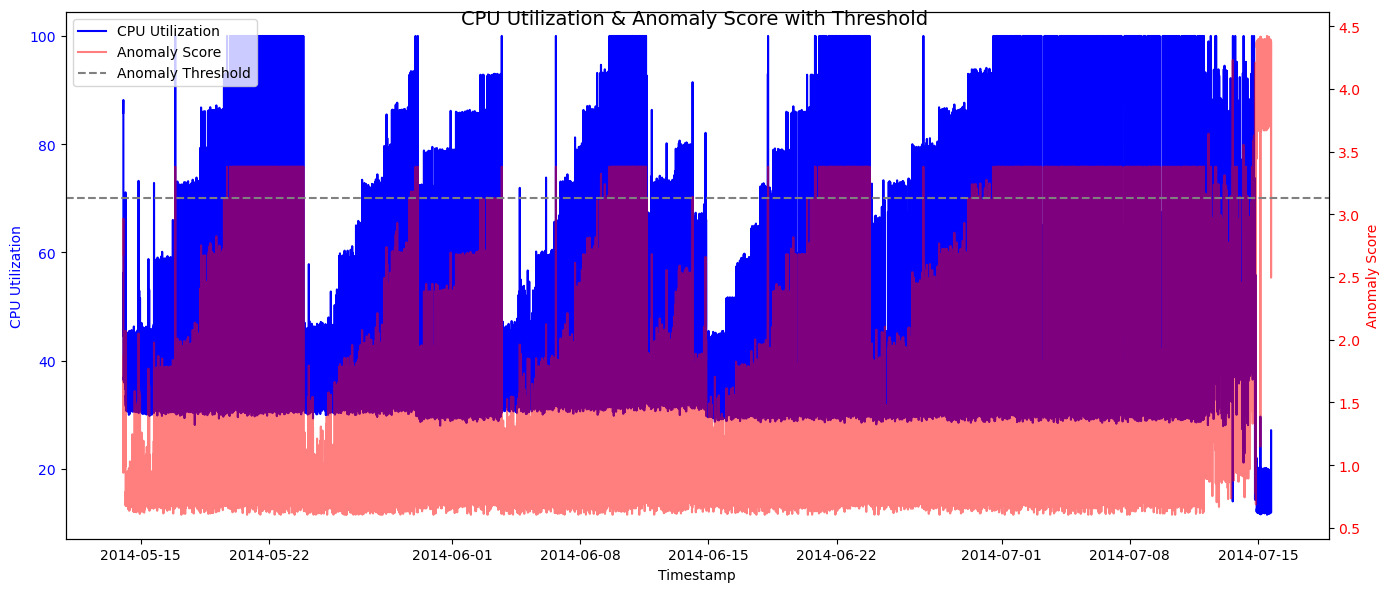

In [41]:
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(df['timestamp'], df['value'], color='blue', label='CPU Utilization')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('CPU Utilization', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df['timestamp'], scores, color='red', alpha=0.5, label='Anomaly Score')
ax2.axhline(y=threshold, color='gray', linestyle='--', label='Anomaly Threshold')
ax2.set_ylabel('Anomaly Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

fig.tight_layout()
fig.suptitle('CPU Utilization & Anomaly Score with Threshold', fontsize=14)
plt.show()


In [33]:
import numpy as np

# 1️⃣ Tính ngưỡng
# Với phương pháp này, chỉ lấy anomaly là top 5% bất thường
# nếu công thức mean + k*std phù hợp với dữ liệu phân phối chuẩn thì cách này lại phù hợp với bất kì
# dạng phân phối dữ liệu nào
# Cách kia cũng nhạy hơn với outlier. Cụ thể là sẽ kéo mean cao lên
threshold = np.percentile(scores, 95)
print(f"Threshold (95th percentile): {threshold:.4f}")

# 2️⃣ Đánh dấu điểm bất thường
outliers = [score > threshold for score in scores]

# 3️⃣ Thêm vào DataFrame
df['anomaly_score'] = scores
df['is_anomaly'] = outliers

print(df.head())


Threshold (95th percentile): 2.6817
             timestamp   value  anomaly_score  is_anomaly
0  2014-05-14 01:14:00  85.835       2.681539       False
1  2014-05-14 01:19:00  88.167       2.964123        True
2  2014-05-14 01:24:00  44.595       0.938640       False
3  2014-05-14 01:29:00  56.282       1.868818       False
4  2014-05-14 01:34:00  36.534       1.350593       False


In [34]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


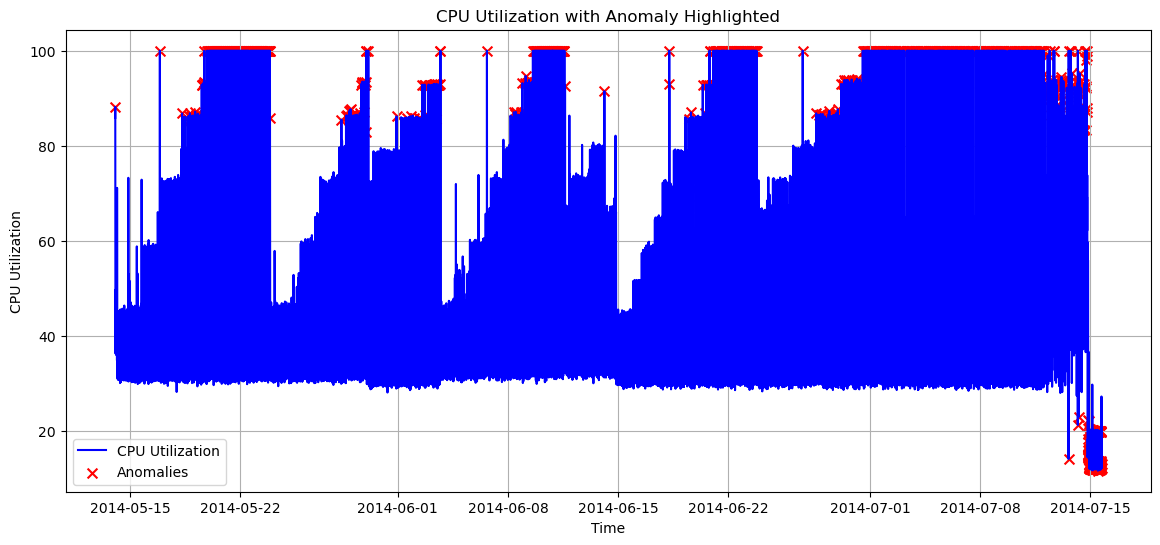

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['value'], label='CPU Utilization', color='blue')

# Vẽ các điểm bất thường
anomaly_points = df[df['is_anomaly']]
plt.scatter(anomaly_points['timestamp'], anomaly_points['value'],
            color='red', label='Anomalies', s=50, marker='x')

plt.xlabel('Time')
plt.ylabel('CPU Utilization')
plt.title('CPU Utilization with Anomaly Highlighted')
plt.legend()
plt.grid()
plt.show()


In [59]:
for i, score in enumerate(scores[:10]):
    print(f"Point {i}: anomaly score = {score:.3f}")


Point 0: anomaly score = 2.682
Point 1: anomaly score = 2.964
Point 2: anomaly score = 0.939
Point 3: anomaly score = 1.869
Point 4: anomaly score = 1.351
Point 5: anomaly score = 1.367
Point 6: anomaly score = 1.360
Point 7: anomaly score = 1.359
Point 8: anomaly score = 1.296
Point 9: anomaly score = 1.478


In [61]:
threshold = 2.0

for i, score in enumerate(scores[:10]):
    if score > threshold:
        print(f"Point {i}: anomaly score = {score:.3f} (ANOMALY)")


Point 0: anomaly score = 2.682 (ANOMALY)
Point 1: anomaly score = 2.964 (ANOMALY)


In [62]:
threshold = 2.0

for i, score in enumerate(scores[:1000]):
    if score > threshold:
        print(f"Point {i}: anomaly score = {score:.3f} (ANOMALY)")


Point 0: anomaly score = 2.682 (ANOMALY)
Point 1: anomaly score = 2.964 (ANOMALY)
Point 34: anomaly score = 2.071 (ANOMALY)
Point 240: anomaly score = 2.049 (ANOMALY)
Point 817: anomaly score = 3.379 (ANOMALY)
Point 851: anomaly score = 2.009 (ANOMALY)


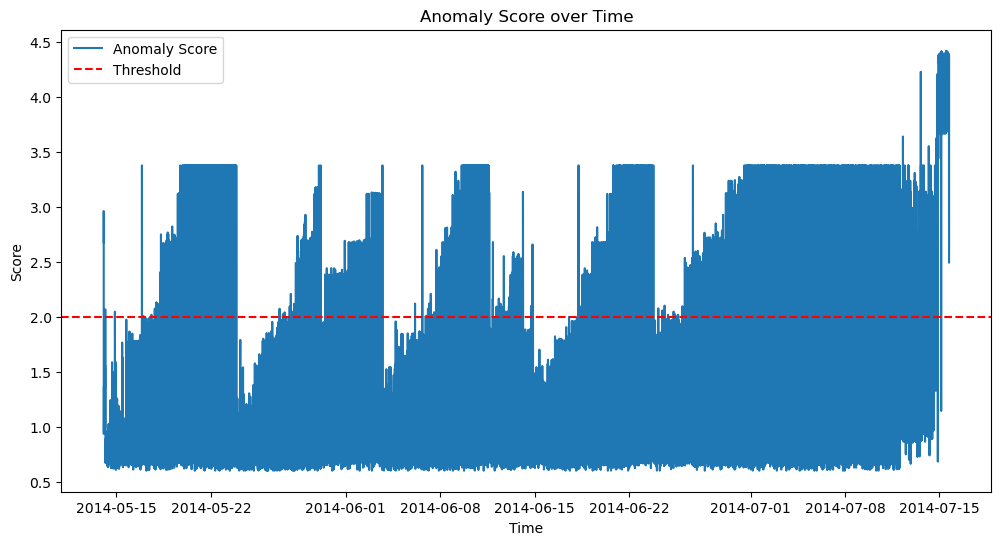

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], scores, label='Anomaly Score')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title('Anomaly Score over Time')
plt.xlabel('Time')
plt.ylabel('Score')
plt.show()


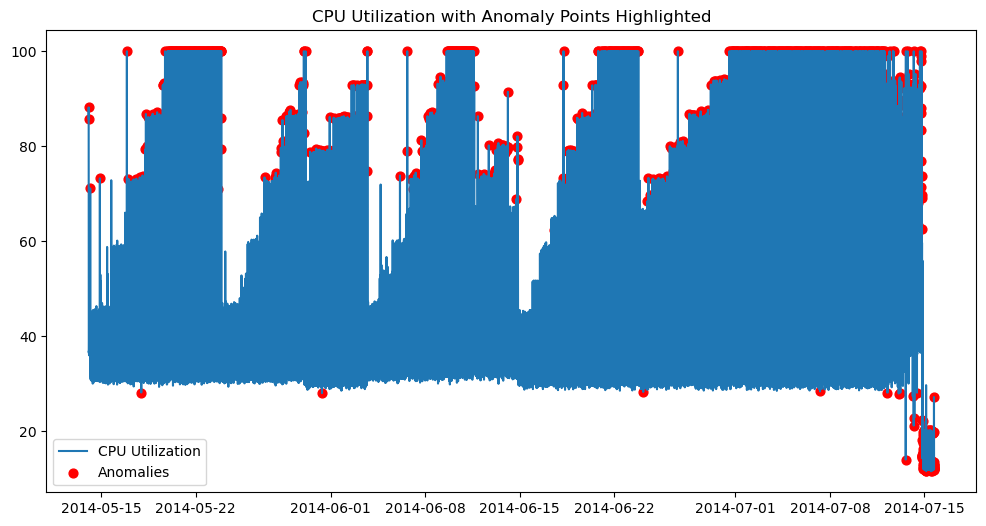

In [64]:
anomaly_indices = np.where(scores > threshold)[0]

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='CPU Utilization')
plt.scatter(df['timestamp'].iloc[anomaly_indices], df['value'].iloc[anomaly_indices],
            color='red', label='Anomalies', s=40)
plt.legend()
plt.title('CPU Utilization with Anomaly Points Highlighted')
plt.show()


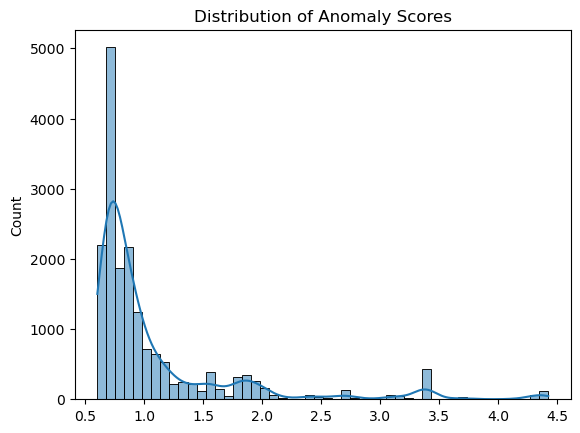

In [65]:
import seaborn as sns
sns.histplot(scores, bins=50, kde=True)
plt.title('Distribution of Anomaly Scores')
plt.show()


Threshold (95th percentile): 2.68
Threshold (98th percentile): 3.38


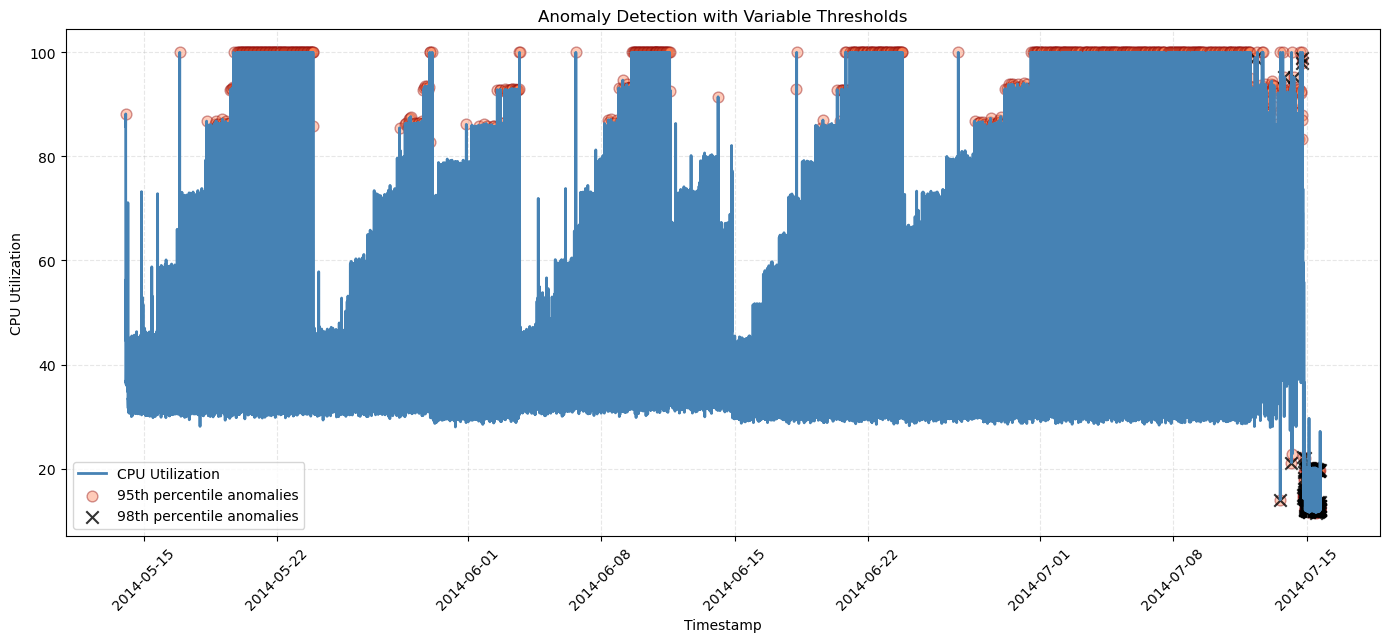

In [73]:
# Threshold dựa trên percentile
threshold_95 = np.percentile(scores, 95)
threshold_98 = np.percentile(scores, 98)

print(f"Threshold (95th percentile): {threshold_95:.2f}")
print(f"Threshold (98th percentile): {threshold_98:.2f}")

# Đánh dấu anomalies
anomalies_95 = scores > threshold_95
anomalies_98 = scores > threshold_98
# Plot
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['value'], color='steelblue', label='CPU Utilization', linewidth=2)

# 95th percentile anomalies (màu cam trong suốt)
plt.scatter(df['timestamp'][anomalies_95], df['value'][anomalies_95],
            color='coral', alpha=0.4, s=60, label='95th percentile anomalies', edgecolor='darkred')

# 98th percentile anomalies (màu đen đậm hơn, rõ hơn)
plt.scatter(df['timestamp'][anomalies_98], df['value'][anomalies_98],
            color='black', marker='x', s=80, label='98th percentile anomalies', alpha=0.8)

plt.xlabel('Timestamp')
plt.ylabel('CPU Utilization')
plt.title('Anomaly Detection with Variable Thresholds')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [74]:
df['year'] = df['timestamp'].dt.year

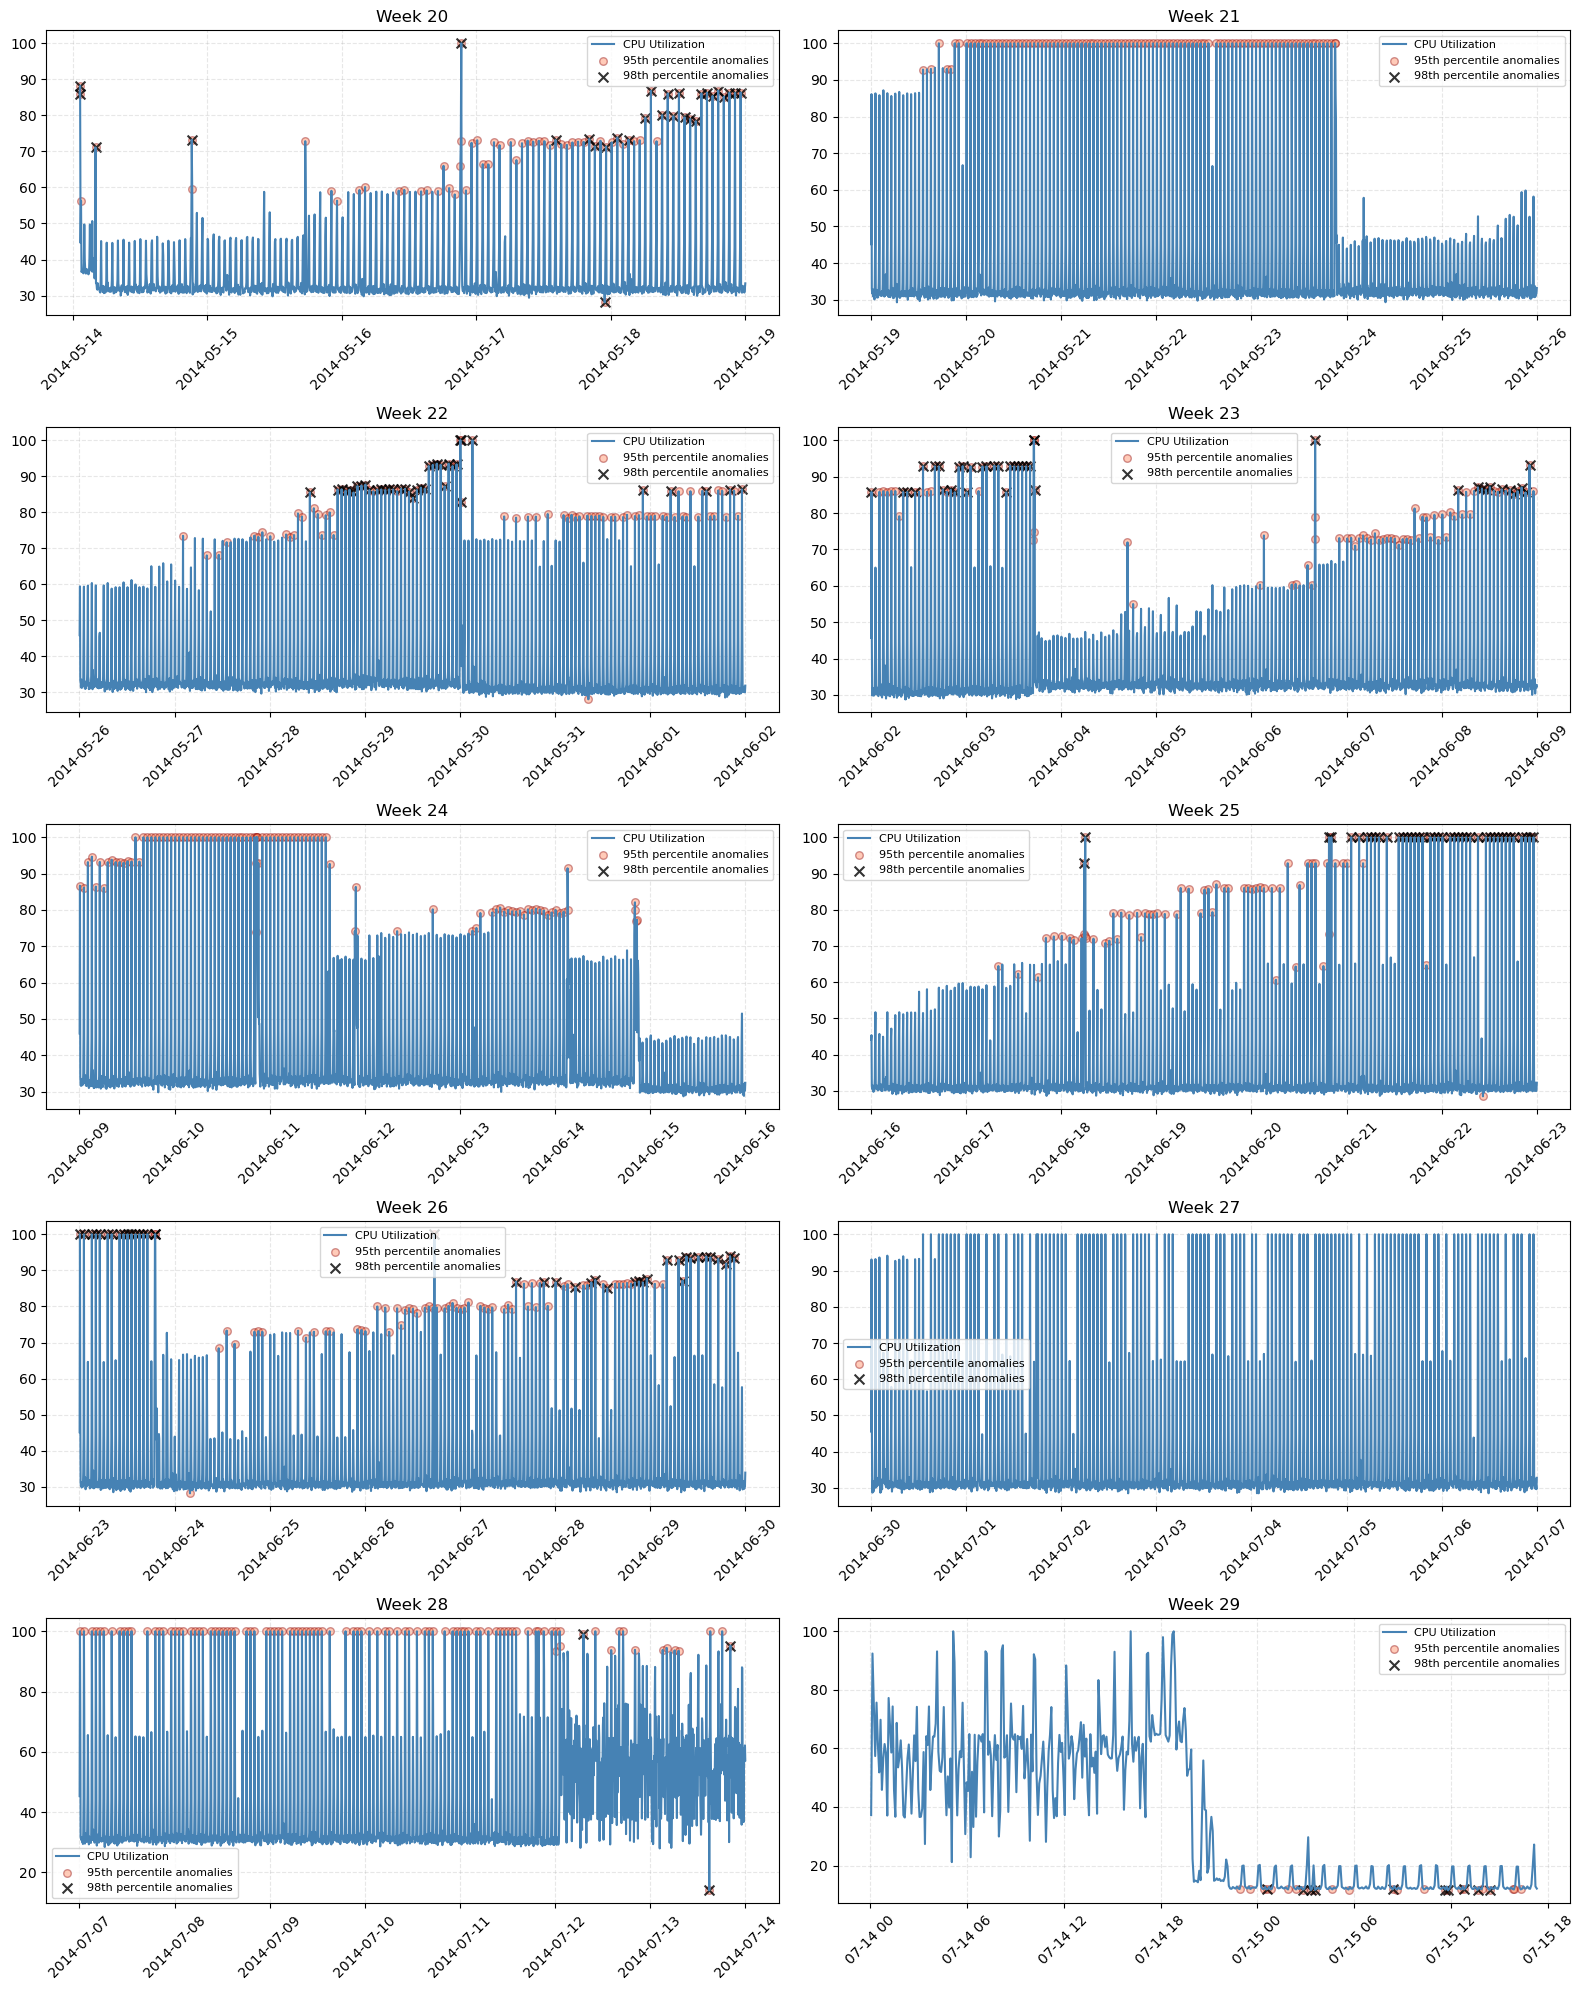

In [75]:
import matplotlib.pyplot as plt

# Make sure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['week'] = df['timestamp'].dt.isocalendar().week

unique_weeks = df['week'].unique()
num_weeks = len(unique_weeks)

# Setup grid layout for subplots (adaptive)
cols = 2
rows = (num_weeks + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4), sharex=False)
axes = axes.flatten()

for i, week in enumerate(sorted(unique_weeks)):
    ax = axes[i]
    week_data = df[df['week'] == week]
    week_scores = scores[week_data.index]

    # Thresholds
    threshold_95 = np.percentile(week_scores, 95)
    threshold_98 = np.percentile(week_scores, 98)
    anomalies_95 = week_scores > threshold_95
    anomalies_98 = week_scores > threshold_98

    ax.plot(week_data['timestamp'], week_data['value'], color='steelblue', label='CPU Utilization', linewidth=1.5)

    # 95th anomalies
    ax.scatter(week_data['timestamp'][anomalies_95], week_data['value'][anomalies_95],
               color='coral', alpha=0.4, s=30, label='95th percentile anomalies', edgecolor='darkred')
    
    # 98th anomalies
    ax.scatter(week_data['timestamp'][anomalies_98], week_data['value'][anomalies_98],
               color='black', marker='x', s=50, label='98th percentile anomalies', alpha=0.8)

    ax.set_title(f'Week {week}')
    ax.legend(fontsize=8)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.3)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


In [3]:
rcf_predictor.delete_endpoint()

NameError: name 'rcf_predictor' is not defined